# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [41]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import mat73
import speckleret as spr

import os
import numpy as np
import h5py
import glob
import scipy.io
import mat73


def _keep_keys(dictionary: dict, keys_to_keep: list[str]) -> dict:
    if keys_to_keep is None:
        return dictionary
    else:
        return {key: value for key, value in dictionary.items() if key in keys_to_keep}



def load_h5file(filepath: str, keys: list[str] = None) -> dict:
    with h5py.File(filepath, 'r') as hf:
        loaded_data = {}
        for key in hf.keys():
            loaded_data[key] = np.array(hf[key])
    return _keep_keys(loaded_data, keys)



data_path = r'C:\Users\saucourt\Downloads\pr_siwar'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the interferometric data

In [78]:
output = True
folder = 'output_frames' if output else 'input_frames'
polar = False if output else True


files = glob.glob(os.path.join(data_path, folder, 'NF*.h5' if output else '*.h5'))
for i in range(len(files)):
    print(f"{i} - {os.path.basename(files[i])}")

frames_path = files[0]
print(f"Loading {os.path.basename(frames_path)}")


if polar:
    with h5py.File(frames_path, 'r') as f:
        CP = f['img_nf'][:][...,0]  # pour une seule polar
        CL = f['img_ff'][:][...,0]	# pour une seule polar
        CP = np.expand_dims(CP, 0)
        CL = np.expand_dims(CL, 0)
else:
    with h5py.File(frames_path, 'r') as f:
        CP = f['frames'][:]
    with h5py.File(os.path.join(data_path, folder, 'FF' + os.path.basename(frames_path)[2:]), 'r') as f:
        CL = f['frames'][:]

print(CP.shape)
print(CL.shape)

0 - NF__captured_frames_20260209-111337_from_opt_20260209-111204.h5
1 - NF__captured_frames_20260209-114534_from_opt_20260209-114439.h5
2 - NF__captured_frames_20260209-114720_from_opt_20260209-114656.h5
3 - NF__captured_frames_20260209-114916_from_opt_20260209-114845.h5
4 - NF__captured_frames_20260209-115046_from_opt_20260209-114656.h5
5 - NF__captured_frames_20260209-115556_from_opt_20260209-115301.h5
6 - NF__captured_frames_20260209-120149_from_opt_20260209-120037.h5
7 - NF__captured_frames_20260209-120231_from_opt_20260209-120211.h5
8 - NF__captured_frames_20260209-120322_from_opt_20260209-120304.h5
9 - NF__captured_frames_20260209-142433_from_opt_20260209-142215.h5
Loading NF__captured_frames_20260209-111337_from_opt_20260209-111204.h5
(1, 388, 388)
(1, 388, 388)


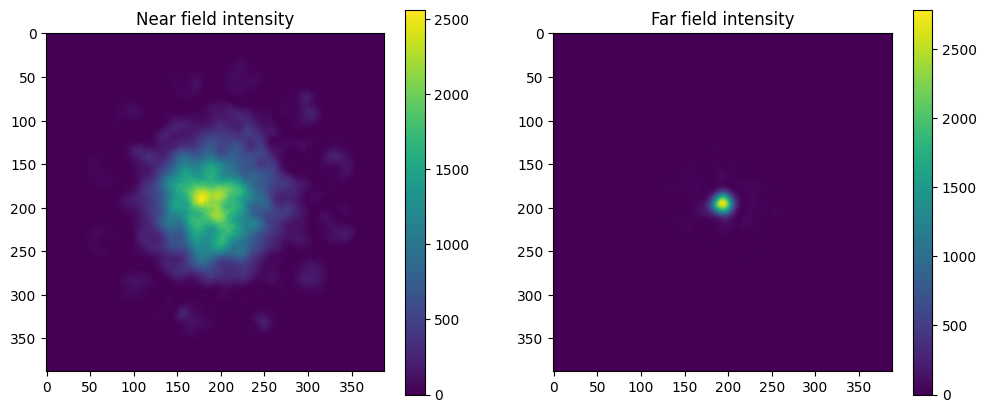

In [79]:
idx = 0

plt.figure(figsize=[12, 5])
plt.subplot(1, 2, 1)
plt.imshow(CP[idx, ...], vmin=0)
plt.title('Near field intensity')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(CL[idx, ...], vmin=0)
plt.title('Far field intensity')
plt.colorbar()

### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

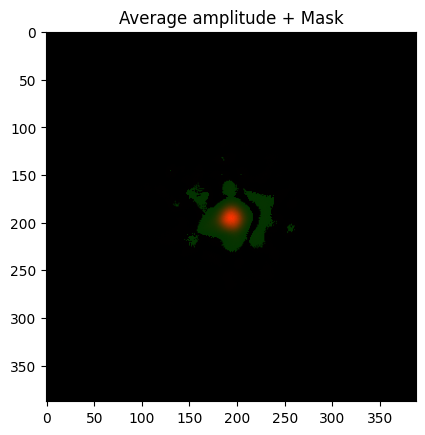

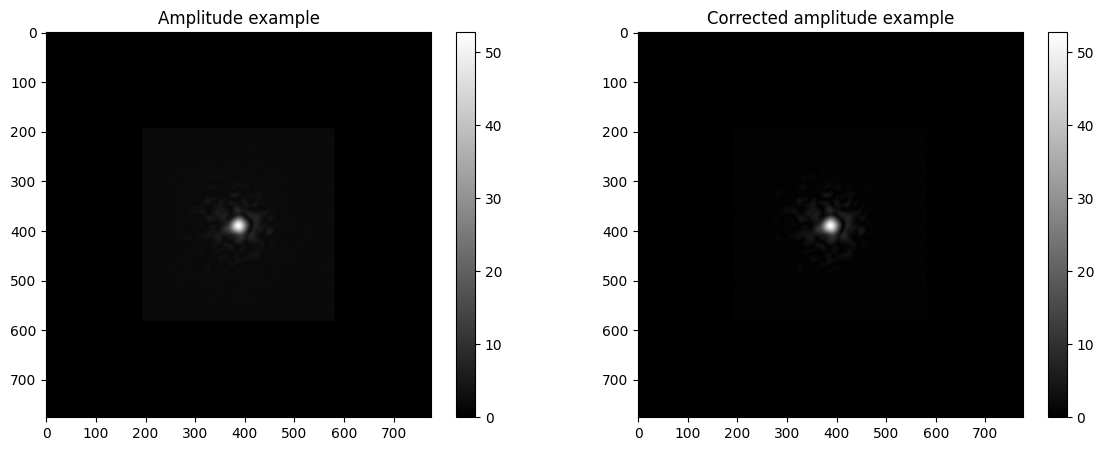

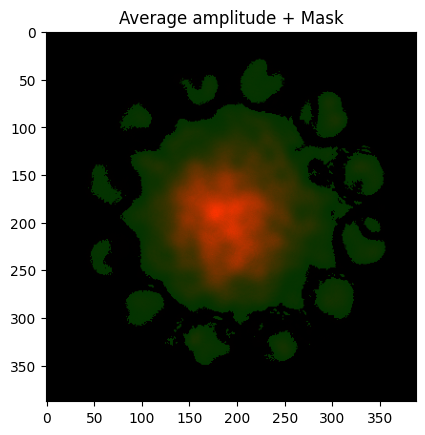

5.976963545541503


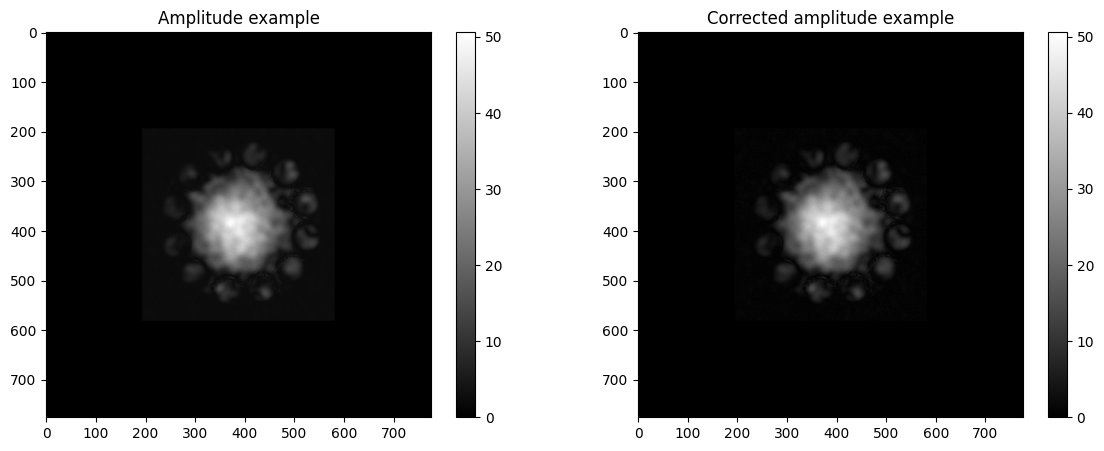

In [80]:
noise_corr = spr.utils.extract_noise_correction(CL, averaging_axis=(0,), mask_trsh=0.01, plot_result=True, plot_mask=True)
noise_corrCP = spr.utils.extract_noise_correction(CP, averaging_axis=(0), mask_trsh=0.01, plot_mask=True, plot_result=True)

print(noise_corr)

Let's detect the average centroids

In [82]:
centroids_CP = spr.utils.extract_average_centroid(CP, averaging_axis=(0, 2))
centroids_CL = spr.utils.extract_average_centroid(CL, averaging_axis=(0, 2))

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (np.float64(193.42922223543644), np.float64(196.26420269688884))
Average centroid CL: (np.float64(193.63304601702598), np.float64(193.1692337090497))


### Data preparation

Select data for phase retrieval

235
(235, 235) 1468158.2641707063
(235, 235) 1468158.2641707063
(235, 235) 80857.81846651962


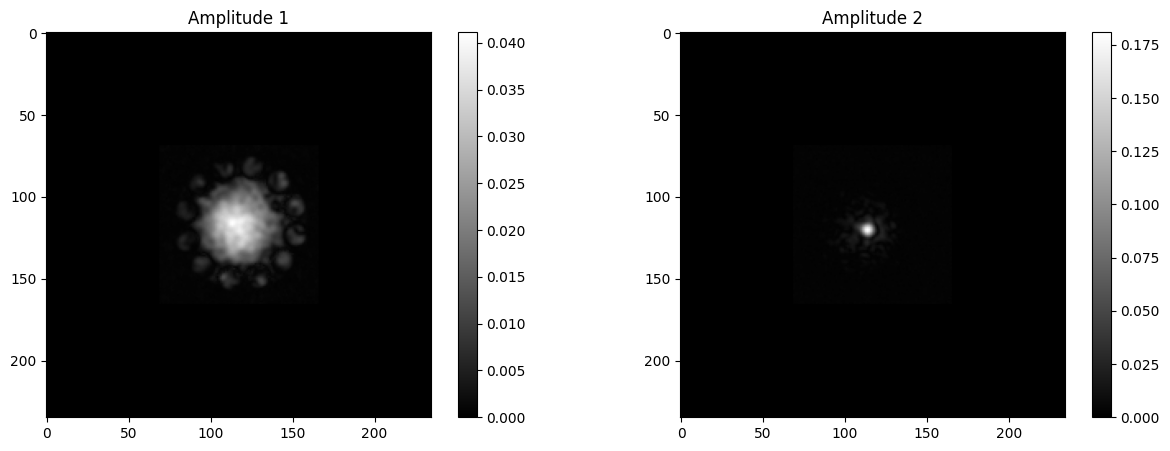

In [126]:
idx = 0
random: bool = False
if random:
    idx = np.random.randint(0, len(CP))


def compute_N_win(wavelength, focal_length, pixel_size1, pixel_size2):
    return int(wavelength * focal_length / (pixel_size1 * pixel_size2))

bin_cp = 4
bin_cl = 4
wavelength = 561.4e-9
focal_length = 80e-3
# focal_length = 240e-3
N_window = compute_N_win(wavelength, focal_length, bin_cp * 1 * 3.45e-6, bin_cl * 1 * 3.45e-6)
print(N_window)


field = np.sqrt(np.abs(CP[idx, ...] - 1 * noise_corrCP)) #

CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int) * 0
field = np.roll(field, shift=-CP_shift, axis=(0,1))

field = spr.utils.bin_image(field, factor=bin_cp)
f_shape = field.shape
f_pad = (N_window - f_shape[0]) // 2
field = np.pad(field, [f_pad, f_pad])

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(np.abs(CL[idx, ...] - 1 * noise_corr)) #
CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) * 0
# ft = np.roll(ft, shift=-5*CL_shift, axis=(0,1))
ft = np.roll(ft, shift=(-15, -12), axis=(0,1))
ft = spr.utils.bin_image(ft, factor=bin_cl)
ft_shape = ft.shape
ft_pad = (N_window - ft_shape[0]) // 2
ft = np.pad(ft, [ft_pad, ft_pad])
ft = np.flip(ft, axis=0)
# ft = np.flip(ft, axis=1)

if field.shape[0] < N_window:
    field = np.pad(field, [0, N_window - field.shape[0]])
if ft.shape[0] < N_window:
    ft = np.pad(ft, [0, N_window - ft.shape[0]])

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)

print(field.shape, field_energy)
print(ft.shape, ft_energy)

_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

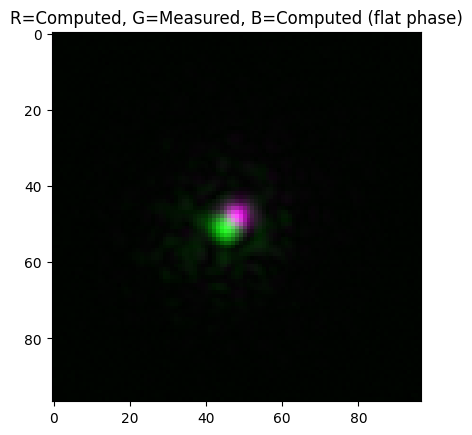

In [127]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)
win_crop = f_pad

R = np.abs(ft_field[win_crop:-win_crop, win_crop:-win_crop])
G = np.abs(ft[win_crop:-win_crop, win_crop:-win_crop])
B = np.abs(ft_field_flat[win_crop:-win_crop, win_crop:-win_crop])

R /= np.max(R)
G /= np.max(G)
B /= np.max(B)

_ = spr.plots.rgb_imshow([R, G, B])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR or OSS works well.

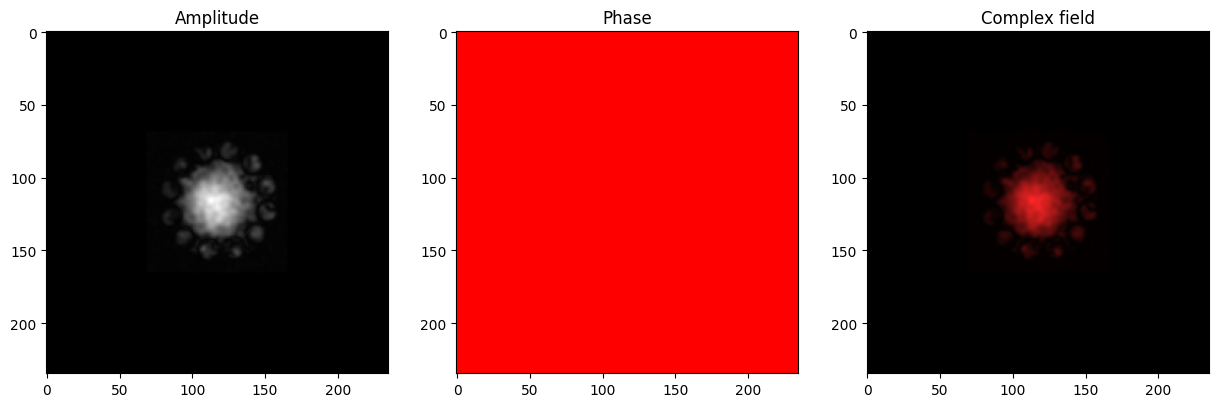

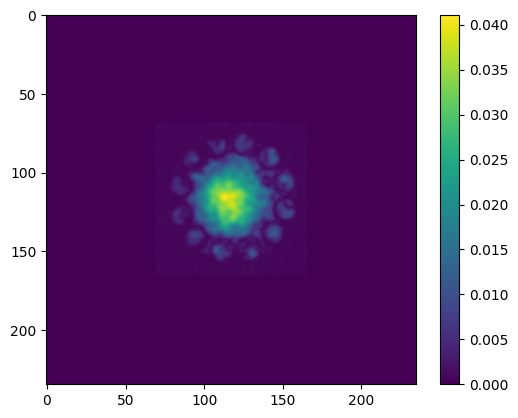

In [128]:
import speckleret.torch as tspr
import torch

tfield = torch.from_numpy(field).to(torch.float)
tfield = tfield.unsqueeze(0).unsqueeze(0)

support = tspr.supports.threshold_support(tfield, threshold=0.00)
# support = tspr.supports.disk_support(tfield, radius=100, offsets=(0,0))
supported_field = tspr.transforms.apply_support(tfield, support)
_ = spr.plots.complex_imshow(supported_field.cpu().detach().numpy().squeeze())

plt.figure()
plt.imshow(supported_field.cpu().detach().numpy().squeeze())
plt.colorbar()

In [129]:
from waveoptics.plots.plots import complex_to_hsv


def merge_dicts(dict_list) -> dict:
    merged_dict = {}
    for d in dict_list:
        for key, array in d.items():
            if key in merged_dict:
                merged_dict[key] = torch.concatenate((merged_dict[key], array))
            else:
                merged_dict[key] = array  # Initialize with first occurrence
    return merged_dict

Total time: 0.7217 seconds


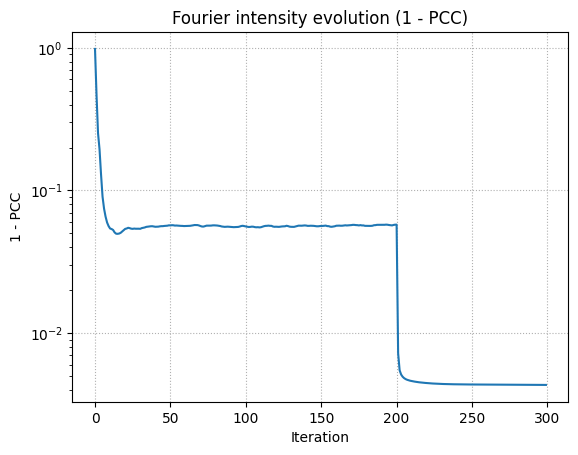

In [130]:
tft = torch.from_numpy(ft).to(torch.float)
tft = tft.unsqueeze(0).unsqueeze(0)


device = 'cuda'

tfield = tfield.to(device)
tft = tft.to(device)
support = support.to(device)



if device.startswith("cuda"):
    torch.cuda.synchronize()
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

results = []

x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(tfield), torch.abs(tft)),
        support=support,
        # init=tspr.initializers.flat_phases(torch.abs(tfield)),
        init=tspr.initializers.random_phases(torch.abs(tfield)),
        algorithm=tspr.retrieval.RAAR,
        algorithm_kwargs={'beta': 0.9},
        max_iter=200,
)
results.append(result)


x, result = tspr.retrieval.run(
        magnitudes=(torch.abs(tfield), torch.abs(tft)),
        support=support,
        init=x,
        algorithm=tspr.retrieval.ER,
        max_iter=100,
)
results.append(result)


end_event.record()
torch.cuda.synchronize()
elapsed_time_ms = start_event.elapsed_time(end_event)
print(f"Total time: {elapsed_time_ms/1000:.4f} seconds")



tspr.retrieval.report_convergence_results(merge_dicts(results), key='pearson_fourier')



x_hat = x
# x_hat = torch.abs(supported_field) * torch.exp(1j * torch.angle(x))
y_hat = tspr.transforms.fourier_transform(x_hat)

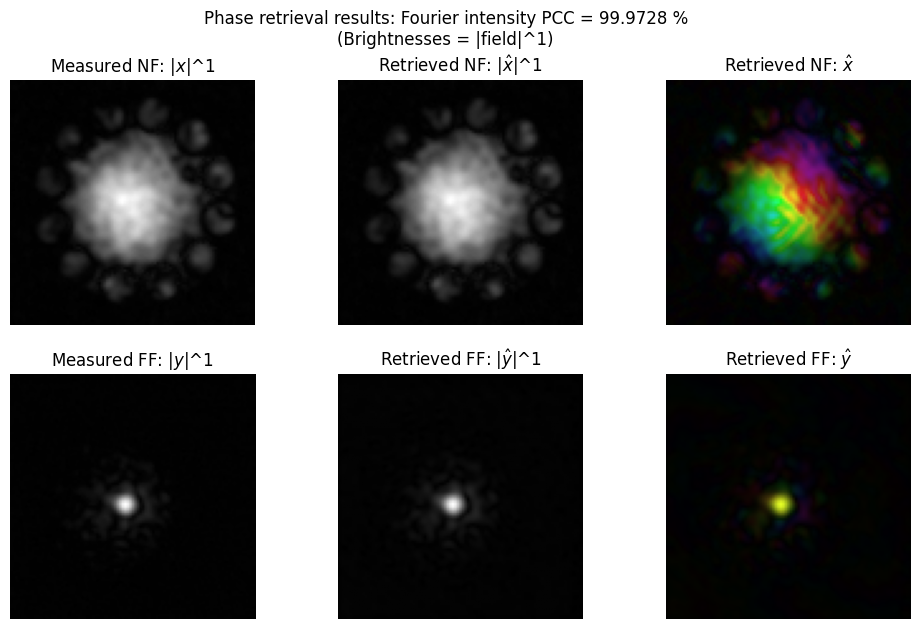

In [131]:
from waveoptics.plots.plots import complex_imshow

hfig = spr.retrievalmath.show_retrieved_fields(
    tfield.cpu().detach().squeeze().numpy(), 
    tft.cpu().detach().squeeze().numpy(),
    x_hat.cpu().detach().squeeze().numpy(),
    y_hat.cpu().detach().squeeze().numpy(),
    power=1,
    window_crop=f_pad,
    window_crop_ff=ft_pad,
)

(2, 2981) (2981,)
fitted: [-0.01189401  0.02103893 -1.03967003]
Std: 1.7132261991500854 rad
Lambda / X rms: 3.7 rms


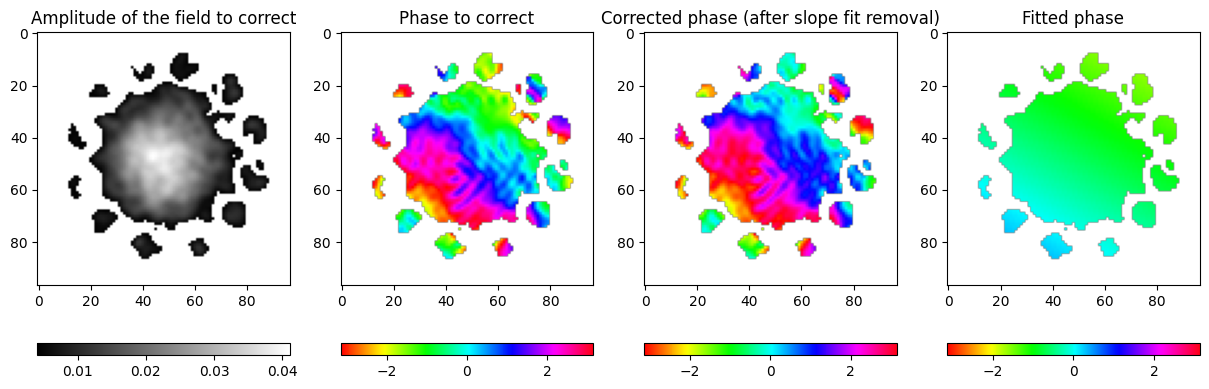

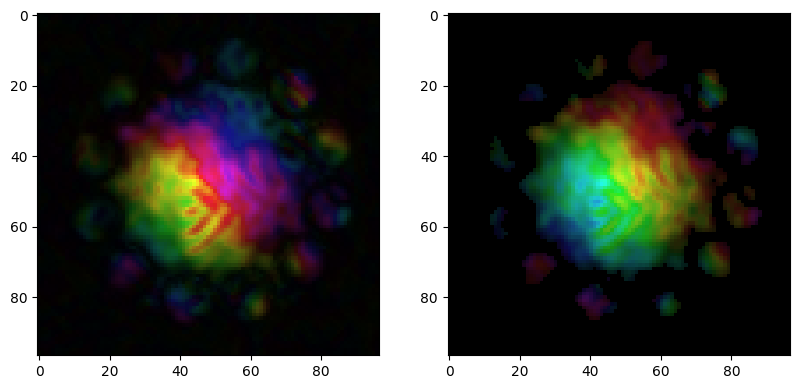

In [136]:
from scipy.optimize import curve_fit

win = f_pad
xx = x_hat.cpu().detach().squeeze().numpy()
xx = xx[win:-win, win:-win]

# support_xx = spr.supports.disk_support(xx, radius=40, offsets=(0, 0)) #* spr.supports.threshold_support(xx, threshold=0.002)
support_xx = spr.supports.threshold_support(xx, threshold=0.01)
# support_xx = 
# support_xx
supported_xx = xx.copy()
supported_xx[np.logical_not(support_xx)] = np.nan
# _ = spr.plots.complex_imshow(supported_xx)

def func_lin(x, a, b, c):
    return a * x[0] + b * x[1] + c

x_grid = np.arange(0, xx.shape[0])
y_grid = np.arange(0, xx.shape[1])
X, Y = np.meshgrid(x_grid, y_grid)
X_supp, Y_supp = X[support_xx], Y[support_xx]
diff = np.angle(supported_xx)

x_fit_data = np.vstack((X_supp.reshape((1, X_supp.size)), Y_supp.reshape((1, Y_supp.size))))
y_fit_data = diff[~np.isnan(diff)] - 1
print(x_fit_data.shape, y_fit_data.shape)

# Curve fit
popt, pcov = curve_fit(func_lin, x_fit_data, y_fit_data, method='lm')
print("fitted: {}".format(popt))
z_fit = func_lin(x_fit_data, *popt)


diff_corr = np.zeros_like(diff) * np.nan
fitted = np.zeros_like(diff) * np.nan
diff_corr[support_xx] = np.angle(np.exp(1j * (diff[support_xx] - z_fit)))
fitted[support_xx] = np.angle(np.exp(1j * z_fit))

xx_corr = np.zeros_like(xx)
xx_corr[support_xx] = np.abs(xx[support_xx]) * np.exp(+1j * diff_corr[support_xx])

print(f"Std: {np.nanstd(diff_corr)} rad")
print(f"Lambda / X rms: {2 * np.pi / np.nanstd(diff_corr):3.1f} rms")



plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(np.abs(supported_xx), cmap='gray')
plt.title("Amplitude of the field to correct")
plt.colorbar(orientation='horizontal')

plt.subplot(1, 4, 2)
plt.imshow(diff, cmap='hsv')
plt.title("Phase to correct")
plt.colorbar(orientation='horizontal')
plt.clim([-np.pi, +np.pi])

plt.subplot(1, 4, 3)
plt.imshow(diff_corr, cmap='hsv')
plt.title("Corrected phase (after slope fit removal)")
plt.colorbar(orientation='horizontal')
plt.clim([-np.pi, +np.pi])

plt.subplot(1, 4, 4)
plt.imshow(fitted, cmap='hsv', vmin=-np.pi, vmax=-np.pi)
plt.title("Fitted phase")
plt.clim([-np.pi, +np.pi])
plt.colorbar(orientation='horizontal')




plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
xx = xx * np.exp(-1j * np.angle(xx[75, 75]))
xx_corr = xx_corr * np.exp(+1j * np.angle(xx_corr[75, 75]))
plt.imshow(spr.plots.complex_to_hsv(np.squeeze(xx), 0, np.max(np.abs(xx))))

plt.subplot(1, 3, 2)
plt.imshow(spr.plots.complex_to_hsv(np.squeeze(xx_corr), 0, np.max(np.abs(xx_corr))))


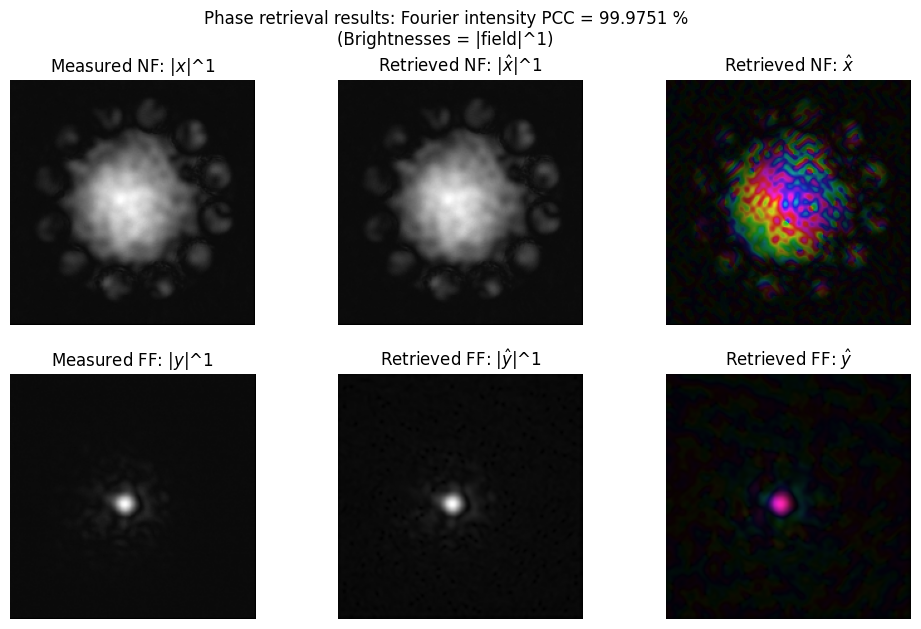

In [90]:
hfig = spr.retrievalmath.show_retrieved_fields(
    tfield.cpu().detach().squeeze().numpy(), 
    tft.cpu().detach().squeeze().numpy(),
    x_hat.cpu().detach().squeeze().numpy(),
    y_hat.cpu().detach().squeeze().numpy(),
    power=1,
    window_crop=f_pad,
    window_crop_ff=ft_pad,
)
# plt.savefig(os.path.join(sav_path, f'pr_result_plot_{savename}.svg'))
# plt.savefig(os.path.join(sav_path, f'pr_result_plot_{savename}.png'))





# plt.figure()
# plt.imshow(spr.plots.complex_to_hsv(np.squeeze(phi), 0, 1))

# plt.savefig(os.path.join(sav_path, f'pr_command_{phi_dim}_{phi_dim}_{expl_number}.svg'))
# plt.savefig(os.path.join(sav_path, f'pr_command_{phi_dim}_{phi_dim}_{expl_number}.png'))

C:\Users\saucourt\AppData\Local\Temp\ipykernel_67352\3240980882.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t1), max(t1), color='blue', alpha=0.2, edgecolor='none', linewidth=0)
C:\Users\saucourt\AppData\Local\Temp\ipykernel_67352\3240980882.py:12: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(min(t2), max(t2), color='purple', alpha=0.2, edgecolor='none', linewidth=0)


Text(0.5, 1.0, 'Phase retrieval: Fourier field PCC')

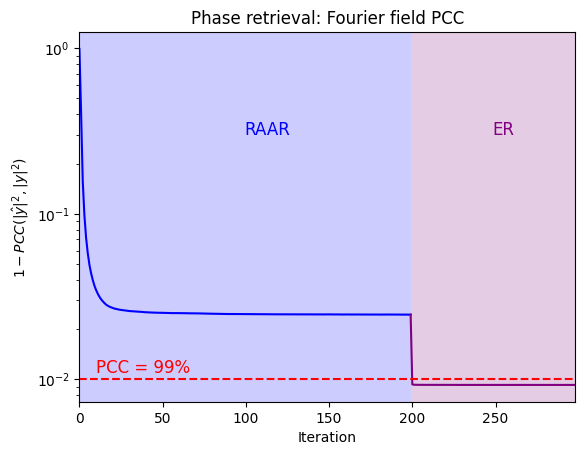

In [21]:
key = 'pearson_fourier'


p1 = results[0][key].cpu()
t1 = torch.arange(0, len(p1))
p2 = results[1][key].cpu()
t2 = torch.arange(len(p1) -1 , len(p1) + len(p2)  -1)

plt.plot(t1, torch.squeeze(p1), label='Algorithm = RAAR', color='blue')
plt.plot(t2, torch.squeeze(p2), label='Algorithm = ER', color='purple')
plt.axvspan(min(t1), max(t1), color='blue', alpha=0.2, edgecolor='none', linewidth=0)
plt.axvspan(min(t2), max(t2), color='purple', alpha=0.2, edgecolor='none', linewidth=0)
plt.axhline(1e-2, color='r', ls='--')
plt.text(10, 1.1e-2, 'PCC = 99%', fontsize=12, color='red')
plt.text(max(t1) // 2, 3e-1, 'RAAR', fontsize=12, color='blue')
plt.text(max(t1) + (max(t2) - max(t1)) // 2, 3e-1, 'ER', fontsize=12, color='purple')

plt.xlim([0, len(p1) + len(p2)-2])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel(r'$1 - PCC(|\hat{y}|^2, |y|^2)$')
# plt.legend()
plt.title('Phase retrieval: Fourier field PCC')




# np.savez(
#     file=os.path.join(sav_path, f'pr_result_data_{savename}.npz'),
#     field=tfield.cpu().numpy(),
#     fourier=tft.cpu().numpy(),
#     retrieved_field=x_hat.cpu().numpy(),
#     retrieved_fourier=y_hat.cpu().numpy(),
#     pr_results=results,
#     bin_cp=bin_cp,
#     bin_cl=bin_cl,
#     N_window=N_window,
#     focal_length=focal_length,
#     wavelength=wavelength,
# )
#
#
#
# plt.savefig(os.path.join(sav_path, f'pr_converg_{savename}.svg'))
# plt.savefig(os.path.join(sav_path, f'pr_converg_{savename}.png'))
